#  Introduction to Image Analysis with Python

Welcome to the "Introduction to Image Analysis with Python" notebook! In this notebook, we will learn how to work with TIFF image datasets in Python for image analysis tasks. We'll explore processing images, preparing them for machine learning algorithms, and understand common operations.

> NOTE: there are many different image file formats used in biological sciences. This notebook focuses on the commonly used [TIFF format](https://en.wikipedia.org/wiki/TIFF) as a starting point.

***Before starting this notebook, make a local copy in your Google Drive by selecting File > Save a Copy in Drive.***


## Load Biomaging Data

In this notebook, we will be using data from the [NASA Biological and Physical Sciences Microscopy Benchmark Training dataset](https://registry.opendata.aws/bps_microscopy/), publicly available on the AWS Open Data Registry.

This dataset contains thousands of images of cellular nuclei from mouse fibroblast cells that have been irradiated with X-rays or high-energy iron (Fe) particles at different doses, and imaged at different timepoints.

The cell nuclei were then stained with a fluorescent marker that adheres to areas of DNA damage and repair, called **53bp1**.

> Thus, when viewing the images, we can see that highly fluorescent areas of the cell nucleus have undergone DNA damage due to radiation exposure. This allows us to study the impact of radiation exposure on the DNA within cells.

More information on this dataset is available [here](https://pubmed.ncbi.nlm.nih.gov/31081741/).


In [19]:
# Install s3fs library
!pip install s3fs

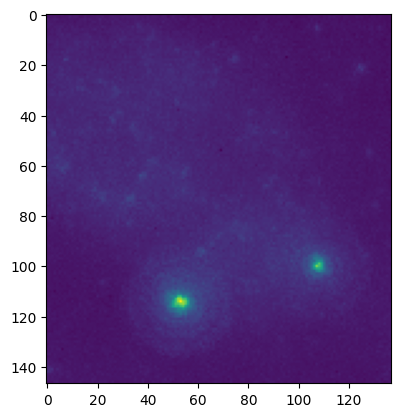

In [20]:
import s3fs
# Import other image processing libraries
from PIL import Image
import matplotlib.pyplot as plt

# Create S3 filesystem object
fs = s3fs.S3FileSystem(anon=True)

# Open the file object from S3
with fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P242_73665006707-A6_011_034_proj.tif/", "rb") as f:
# Open the image using Pillow
  img = Image.open(f)
  plt.imshow(img)


The image above shows a nucleus that was exposed to high-energy Fe particles at a dose of 0.82 [Gray](https://en.wikipedia.org/wiki/Gray_(unit) (Gy), captured 4 hours after exposure.

The nucleus is barely visible against the background, with 2 points of DNA damage visible as bright fluorescent spots.


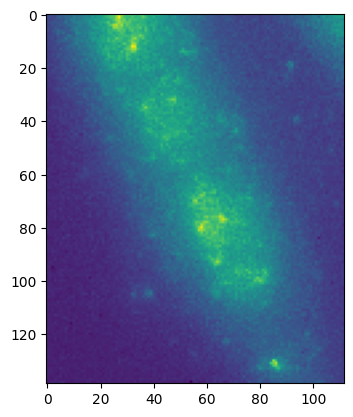

In [21]:
# Open another image
with fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P279_73668277350-E2_028_007_proj.tif/", "rb") as f:
# Open the image using Pillow
  img = Image.open(f)
  plt.imshow(img)

This second image shows a nucleus that was exposed to low-energy X-rays at a dose of 0.1 Gy, captured 4 hours after exposure.

> **Challenge Question:** How does the pattern of DNA damage differ between the Fe and X-ray exposures?

**Double-click here to enter your answer below.**

Answer:


----

## Image Preprocessing

Now that we can access the bioimaging dataset, let's explore several common techniques for preprocessing images prior to training a machine learning model. We will use two Python libraries for these tasks: [Matplotlib](https://matplotlib.org/) and [Pillow](https://pypi.org/project/pillow/).


### Image Resizing

Images can come in all sorts of sizes. Preprocessing often involves **resizing** them to a standard size that the machine learning model expects. This ensures all images are treated equally and simplifies processing for the model.

We'll use Pillow to open one of the radiation images and resize it using the `thumbnail` method.

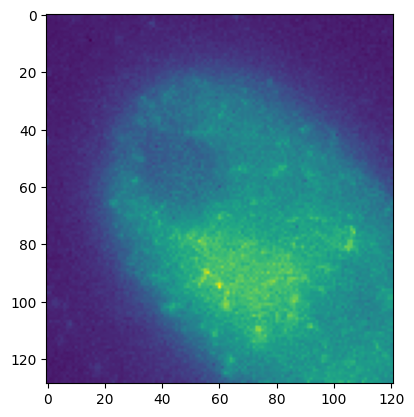

In [22]:
# First, let's view the image we want to resize
f = fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P251_73665707362-C6_016_004_proj.tif/", "rb")
img = Image.open(f)
plt.imshow(img)

> **CHALLENGE QUESTION:** Approximately what are the pixel dimensions of this original image? (HINT: look at the axis labels)

**Double click here to enter your answer below.**

Answer:

---

Now, let's resize that image to a specific size: 580 pixels by 1000 pixels, using the `resize()` function.

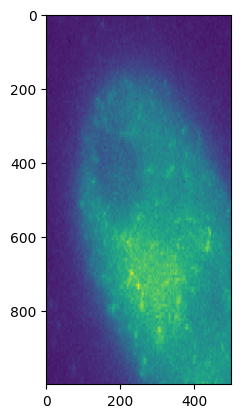

In [23]:
# Resize the image to a specific size (550x1000 in this example)
resized_image = img.resize((500, 1000))

# Display the original and resized image (optional)
plt.imshow(resized_image)

> **CHALLENGE QUESTION:** Did the resizing preserve the [aspect ratio](https://en.wikipedia.org/wiki/Aspect_ratio_(image) (relationship of width to height) of the original image, or did it stretch it in a certain dimension?

**Double click here to enter your answer below.**

Answer:

----

**Note of Caution:**

As you can see, since resizing an image has the potential to change the aspect and *stretch* the image, it is important to evaluate whether resizing is appropriate for your dataset and machine learning model.

### Normalization

The intensity values of pixels in an image can vary greatly. In machine learning, particularly when dealing with deep neural networks, image normalization is sometimes a necessary preprocessing step. It aims to standardize the pixel intensity values across an entire image dataset. This is similar to ensuring all your ingredients are measured using the same units in a recipe.

Normalization techniques adjust the pixel intensity values to a specific range, like 0 to 1 or -1 to 1. This helps the machine learning model train more efficiently.

We'll use NumPy to convert an image to an array and then normalize the pixel values by dividing each element (pixel) in the array by 740.0, the maximum pixel intensity in the original image, effectively scaling the values between 0 and 1.

In [24]:
import numpy as np

# Get the image we want to normalize
f = fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P251_73665707362-C6_016_004_proj.tif/", "rb")

# Convert the image to a NumPy array
image_array = np.array(img)

# Print the minimum and maximum values of the normalized array
print(f"Original image: Minimum pixel intensity: {image_array.min()}, Maximum pixel intensity: {image_array.max()}")

# Normalize the pixel values between 0 and 1 by dividing by the maximum pixel intensity
image_norm = image_array.astype(np.float32) / 740.0

# Print the minimum and maximum values of the normalized array
print(f"Normalized image: Minimum pixel intensity: {image_norm.min()}, Maximum pixel intensity: {image_norm.max()}")

Original image: Minimum pixel intensity: 158, Maximum pixel intensity: 740
Normalized image: Minimum pixel intensity: 0.21351350843906403, Maximum pixel intensity: 1.0


> **CHALLENGE QUESTIONS:** What was the minimum pixel intensity of the original image? Did the normalization bring the maximum and minimum intensity between 0 and 1?

**Double click here to enter your answers below.**

Answer:

----

**Note of Caution:**

In many bioimaging applications, such as microscopy, the *intensity* of pixels in the image is the important feature, as compared to the *shape* of features within the image. In these cases, it is important NOT to normalize or scale the pixel intensity of the image, because this process will amplify background noise and distort the biological signal.


### Cropping

Images might not always be perfectly centered or oriented. **Cropping** removes irrelevant parts of the image and focuses on the region of interest.

In the code below, we'll use Pillow to define a bounding box and crop the image just to the edges of the nucleus.

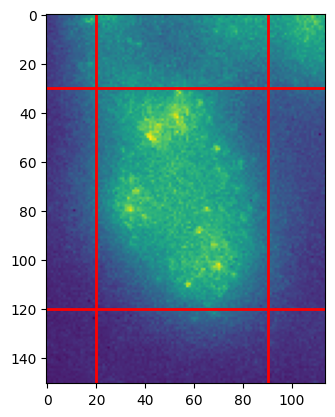

In [25]:
# Let's look at the image before we crop it
f = fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P279_73668277350-E1_018_022_proj.tif/", "rb")
img = Image.open(f)

# Plot vertical lines in red color
plt.axvline(x=20, color='red', linewidth=2)
plt.axvline(x=90, color='red', linewidth=2)

# Plot horizontal lines in red color
plt.axhline(y=30, color='red', linewidth=2)
plt.axhline(y=120, color='red', linewidth=2)

plt.imshow(img)

In the image above, red lines have been drawn to capture the nucleus in the middle. Next, we will crop the image.

We define a **bounding box** as a tuple containing coordinates for the left, top, right, and bottom of the desired region.

We use the `crop()` function to extract the portion of the image within the specified bounding box.

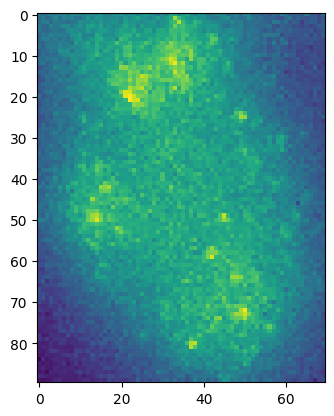

In [26]:
# Define the bounding box (left, top, right, bottom)
box = (20, 30, 90, 120)

# Crop the image
cropped_image = img.crop(box)

# Display the original and cropped image (optional)
plt.imshow(cropped_image)

----
### Rotation

 **Rotation** techniques can straighten tilted images, ensuring the objects are upright for better analysis.

 In the code below, we'll use Pillow to rotate the cropped image by a specific angle, using the `.rotate()` function which rotates the image by the specified angle (in degrees). Negative values rotate counter-clockwise.

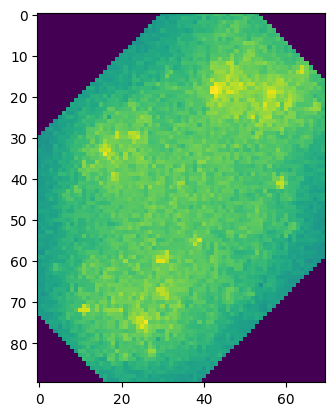

In [27]:
# Rotate the image by 45 degrees counter-clockwise
rotated_image = cropped_image.rotate(-45)

# Display the original and rotated image (optional)
plt.imshow(rotated_image)

### Image Augmentation

**Image augmentation** is a technique used in machine learning to artificially create variations of your existing training data.

Image augmentation injects variety into the training set. By introducing random transformations like rotations, flips, cropping, and brightness adjustments, the model encounters the same object from various perspectives and lighting conditions. This forces the model to focus on learning robust features that are consistent across these variations, improving its ability to generalize to new data.

Real-world images often exhibit variations due to camera angles, lighting, and environmental factors. Image augmentation helps the model become more robust to these variations. By encountering a wider range of image transformations during training, the model learns to extract the essential features of an object regardless of its pose, lighting, or background clutter. This translates to better performance on real-world data that might not perfectly match the training images.

Below, we will implement one type of augmentation, random flipping of an image.

**Random Flipping:**

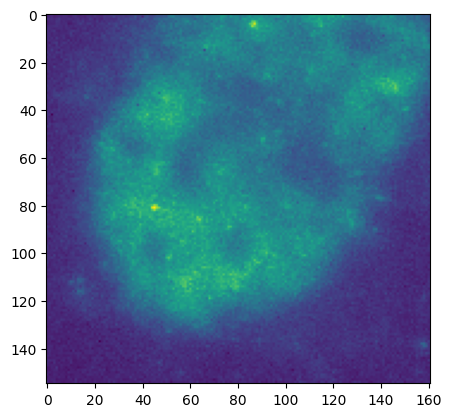

In [28]:
 # Let's look at the image before we flip it
f = fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P287_73668956345-E5_012_036_proj.tif/", "rb")
img = Image.open(f)
plt.imshow(img)


Now, let's randomly flip the image horizontally.

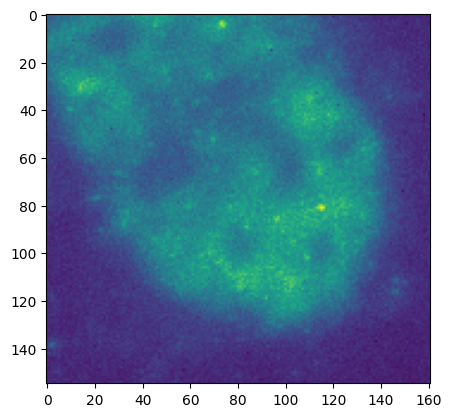

In [29]:
import random

# Randomly flip the image horizontally
if random.random() > 0.5:
  image = img.transpose(Image.FLIP_LEFT_RIGHT)

# Display the original or flipped image (optional)
plt.imshow(image)

**Image Segmentation Example**

Image segmentation is a fundamental technique in computer vision that aims to partition an image into distinct regions corresponding to objects, parts of objects, or meaningful groupings of pixels.

By isolating individual objects in an image, segmentation paves the way for object detection and recognition algorithms to identify and classify those objects more accurately.

Below, we use image segmentation to separate the brighter cell nucleus from the darker background, by creating a **mask** overlaid on the original image. The mask is a black and white image with the same size as the original image. White pixels in the mask represent the foreground object you're interested in (the nucleus). Black pixels represent the background.


In [30]:
pip install pybiomart

Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 89.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 63.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


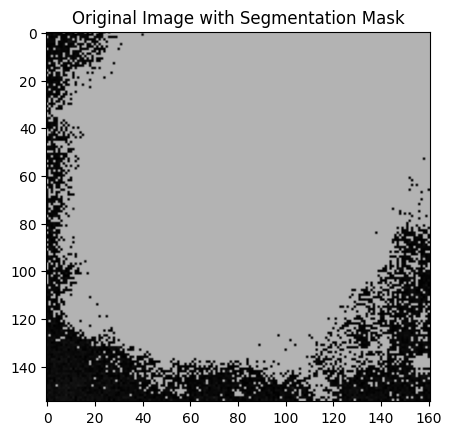

In [33]:
import matplotlib.pyplot as plt
from skimage import io, color

f = fs.open(f"s3://nasa-bps-training-data/Microscopy/train/P287_73668956345-E5_012_036_proj.tif/", "rb")
img = io.imread(f)

# Invert the image intensity values since the image background is darker than the region of interest
inverted_image = 255 - img

# Add a dummy channel so it can be converted to RGB space
image = np.stack((inverted_image,) * 3, axis=-1)

# Convert the image to LAB colorspace
lab_image = color.rgb2lab(image)

# Define a threshold for separating the foreground
threshold = 100

# Create a binary mask where pixels above the threshold are considered foreground
mask = lab_image[:,:,0] > threshold

# Display the original image and segmentation mask (optional)
plt.imshow(image)
plt.imshow(mask, alpha=0.3, cmap='gray')  # Overlay mask on top with transparency
plt.title('Original Image with Segmentation Mask')
plt.show()